# Beetaloo: MICE (max_iter=10), EDA

In [3]:
# import libraries
import numpy as np
import pandas as pd

import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import KFold, GroupKFold

from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time


# 1. Data Pre-processing

## 1.1. Data Loading

In [4]:
# beetaloo dataset
beetaloo = pd.read_csv(filepath_or_buffer='dataset_beetaloo.csv', low_memory=False)
beetaloo.head()

,WELL_ID,YEAR,LATITUDE,LONGITUDE,DEPTH,DENSITY,GR,SONIC,RESISTIVITY,SP,NEUTRON,CALIPER,BITSIZE,TOC_CORE,TOC_CUTTINGS,LITHO,ORDER_3,ORDER_4
0,Alexander_1,1988.0,-15.16911,134.855921,63.1,NaN,111.753,NaN,NaN,NaN,NaN,4.705,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
1,Alexander_1,1988.0,-15.16911,134.855921,63.2,NaN,108.300,NaN,NaN,NaN,NaN,4.701,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
2,Alexander_1,1988.0,-15.16911,134.855921,63.3,NaN,105.699,NaN,NaN,NaN,NaN,4.676,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
3,Alexander_1,1988.0,-15.16911,134.855921,63.4,NaN,106.119,NaN,NaN,NaN,NaN,4.668,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
4,Alexander_1,1988.0,-15.16911,134.855921,63.5,NaN,106.734,NaN,NaN,NaN,NaN,4.691,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5


## 1.2. Data Information

In [5]:
# dataset shape
print(f"Number of Samples: {beetaloo.shape[0]}")
print(f"Number of Features: {beetaloo.shape[1]} \n")

# number of wells
print(f"Number of Wells: {len(beetaloo['WELL_ID'].unique())}")

Number of Samples: 352143
Number of Features: 18 

Number of Wells: 32


In [6]:
# general information about the dataset
beetaloo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352143 entries, 0 to 352142
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   WELL_ID       352143 non-null  object 
 1   YEAR          328712 non-null  float64
 2   LATITUDE      238088 non-null  float64
 3   LONGITUDE     238088 non-null  float64
 4   DEPTH         352143 non-null  float64
 5   DENSITY       227657 non-null  float64
 6   GR            215742 non-null  float64
 7   SONIC         252256 non-null  float64
 8   RESISTIVITY   282280 non-null  float64
 9   SP            200326 non-null  float64
 10  NEUTRON       168539 non-null  float64
 11  CALIPER       85689 non-null   float64
 12  BITSIZE       85121 non-null   float64
 13  TOC_CORE      1804 non-null    float64
 14  TOC_CUTTINGS  1895 non-null    float64
 15  LITHO         326708 non-null  object 
 16  ORDER_3       352143 non-null  object 
 17  ORDER_4       352143 non-null  object 
dtypes: f

In [7]:
# descriptive statistics for numerical variables
beetaloo.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
YEAR,328712.0,2010.69,9.26,1984.00,2014.00,2015.00,2015.00,2016.00
LATITUDE,238088.0,-16.29,0.49,-17.39,-16.40,-16.35,-16.29,-14.76
LONGITUDE,238088.0,133.95,0.57,132.68,133.61,133.76,134.70,134.86
DEPTH,352143.0,1414.14,924.82,1.40,613.81,1287.57,2050.69,3920.03
DENSITY,227657.0,2.63,0.17,1.21,2.56,2.62,2.68,4.63
GR,215742.0,145.88,58.58,3.61,115.01,152.15,181.38,422.92
SONIC,252256.0,78.65,13.25,-299.28,69.17,77.92,88.41,145.84
RESISTIVITY,282280.0,637.34,7336.28,-864.44,12.53,22.70,46.00,100000.00
SP,200326.0,-36.58,101.26,-283.75,-124.52,-6.89,41.39,225.62
NEUTRON,168539.0,2.66,6.80,-0.35,0.12,0.17,0.22,40.20


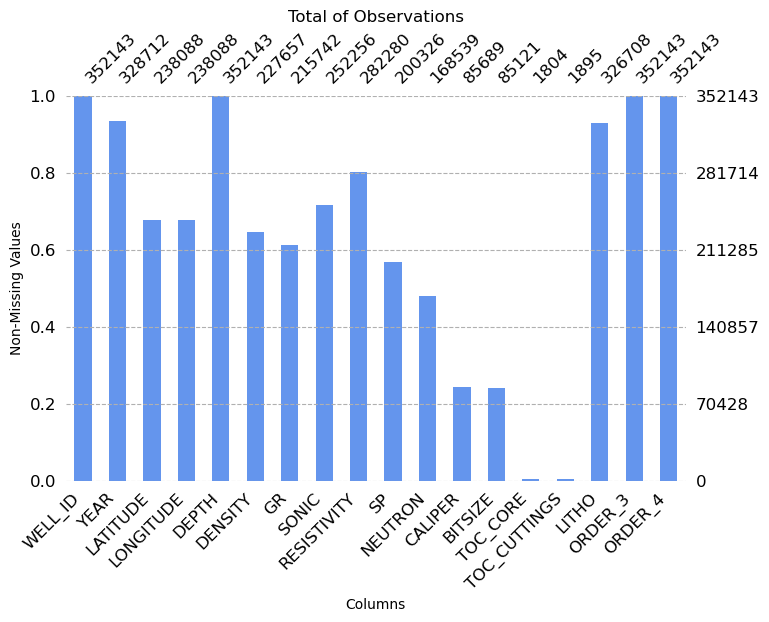

In [8]:
# check for missing values and visualize missingness using a bar plot
fig, axes = plt.subplots(figsize=(8, 5))

msno.bar(df=beetaloo, ax=axes, fontsize=12, color='cornflowerblue')

axes.set_xlabel('Columns')
axes.set_ylabel('Non-Missing Values')
axes.set_title('Total of Observations')
axes.grid(axis='y', linestyle='--')

plt.show()

In [9]:
# missing values per column
beetaloo.isna().sum()

WELL_ID              0
YEAR             23431
LATITUDE        114055
LONGITUDE       114055
DEPTH                0
DENSITY         124486
GR              136401
SONIC            99887
RESISTIVITY      69863
SP              151817
NEUTRON         183604
CALIPER         266454
BITSIZE         267022
TOC_CORE        350339
TOC_CUTTINGS    350248
LITHO            25435
ORDER_3              0
ORDER_4              0
dtype: int64

## 1.3. Data Cleaning

### Renaming Columns

In [10]:
# rename columns
beetaloo.rename(columns={'DENSITY': 'RHOB', 
                         'SONIC': 'DT',
                         'RESISTIVITY': 'RES', 
                         'NEUTRON': 'NPHI',
                         'ORDER_4': 'STRAT'
                        }, inplace=True
               )

### Completing Missing Data

It can be seen that some wells have no year and location information. For this reason, it is necessary to complete this information using Geoscience Exploration and Mining Information System ([GEMIS](https://geoscience.nt.gov.au/gemis/ntgsjspui/community-list)).
Additionally, since there were coordenates in Geoscience Australia Lambert (GDA94), they were converted to World Geodetic System 1984 (WGS84).
To do so, it is imported the library pyproj which uses epsg codes:
- GDA94: 3112
- WGS84: 4326

In [11]:
# complete the years of some wells
wells_no_year = ['Balmain_1', 'Jamison_1', 'Lady_Penrhyn_1', 'Ronald_1', 'Scarborough_1', 'Sever_1', 'Walton_2']
years = [1992, 1991, 1987, 1993, 1987, 1990, 1989]

for i in range(len(wells_no_year)):
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_year[i], 'YEAR'] = years[i] 
    
    
# complete the location of some wells
wells_no_location = ['Balmain_1', 'Birdum_Creek_1', 'Broadmere_1', 'Jamison_1', 'Lady_Penrhyn_1', 'Marmbulligan_1', 'Ronald_1', 'Scarborough_1', 'Sever_1', 'Tarlee_1', 'Walton_2', 'Wyworrie_1']

x_coord = [-92402.40724, 142017.0021, -24907.23409, -501.9841485, 82970.28312, 17486.61935, 86665.76837, -125242.803, -124956.7945, -38322.74503, -135702.1635]
y_coord = [-1809383.515, -1887528.408, -1936401.136, -1747313.691, -1872700.38, -1877801.953, -1759280.809, -1766817.469, -1845740.884, -1839970.706, -1780656.283]

lat = [-16.620444] 
lon = [133.577361]



# convert GDA94 to WGS84
import pyproj
# GDA94 / Geoscience Australia Lambert, EPSG:3112
# WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS, EPSG:4326
gda94_wgs84 = pyproj.Transformer.from_crs(3112, 4326)
for i in range(len(x_coord)):
    new_coord = gda94_wgs84.transform(x_coord[i], y_coord[i])
    lat.append(new_coord[0])
    lon.append(new_coord[1])

# replace coordinates in the dataset
for i in range(len(wells_no_location)):
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_location[i], 'LATITUDE'] = lat[i]
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_location[i], 'LONGITUDE'] = lon[i]

In [12]:
beetaloo.rename(columns={'LONGITUDE': 'X',
                         'LATITUDE' : 'Y'}, inplace=True)

#### Dropping Unnecessary Columns

In [13]:
# drop columns
beetaloo.drop(['YEAR', 'CALIPER', 'BITSIZE', 'TOC_CORE', 'TOC_CUTTINGS', 'ORDER_3'], axis=1, inplace=True)

#### Handling Outliers and Well-Log Transformation

In [14]:
# replace sonic values smaller than 0 for NaN values
mask = beetaloo['DT'] < 0
beetaloo.loc[mask, 'DT'] = np.nan

# replace resistivity values smaller than or equal to 0 for NaN values
mask = beetaloo['RES'] <= 0
beetaloo.loc[mask, 'RES'] = np.nan

# create a new column to store log base 10 of resistivity
beetaloo['RES_10'] = np.log10(beetaloo['RES']+1)

# replace neutron porosity values smaller than 0 for NaN values
mask = beetaloo['NPHI'] < 0
beetaloo.loc[mask, 'NPHI'] = np.nan

# convert percentage to fraction
def convert_neutron(x):
    if x >= 1:
        return x / 100
    else:
        return x

beetaloo['NPHI'] = beetaloo['NPHI'].apply(convert_neutron)

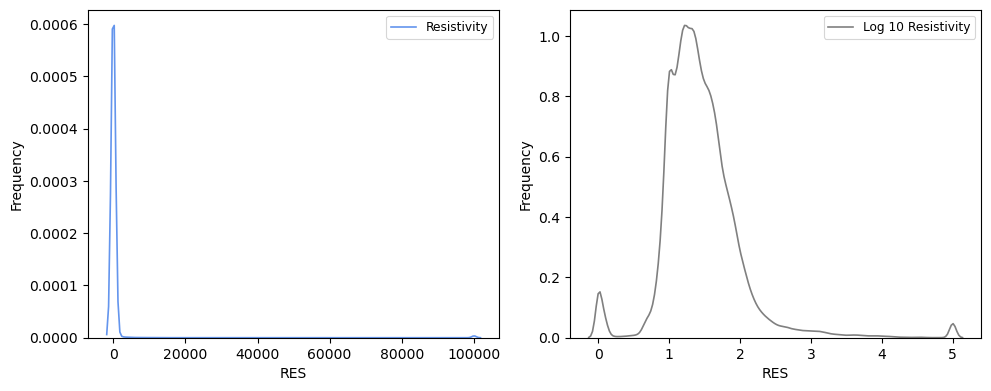

In [15]:
# histogram of resistivity vs log 10 resistivity
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.set_context('paper')

sns.kdeplot(beetaloo['RES'], color='cornflowerblue', ax=axes[0], label='Resistivity')
axes[0].set_xlabel('RES')
axes[0].set_ylabel('Frequency')
axes[0].legend()

sns.kdeplot(beetaloo['RES_10'], color='grey', ax=axes[1], label='Log 10 Resistivity')
axes[1].set_xlabel('RES')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()


## 1.4. Exploratory Data Analysis (EDA)

### Data Summary

In [16]:
# dataset shape
print(f"Number of Samples: {beetaloo.shape[0]}")
print(f"Number of Features: {beetaloo.shape[1]} \n")

# number of wells
print(f"Number of Wells: {len(beetaloo['WELL_ID'].unique())}")

Number of Samples: 352143
Number of Features: 13 

Number of Wells: 32


In [17]:
beetaloo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352143 entries, 0 to 352142
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   WELL_ID  352143 non-null  object 
 1   Y        352143 non-null  float64
 2   X        352143 non-null  float64
 3   DEPTH    352143 non-null  float64
 4   RHOB     227657 non-null  float64
 5   GR       215742 non-null  float64
 6   DT       252249 non-null  float64
 7   RES      282225 non-null  float64
 8   SP       200326 non-null  float64
 9   NPHI     168481 non-null  float64
 10  LITHO    326708 non-null  object 
 11  STRAT    352143 non-null  object 
 12  RES_10   282225 non-null  float64
dtypes: float64(10), object(3)
memory usage: 34.9+ MB


In [18]:
cols_statistics = ['WELL_ID', 'DEPTH', 'RHOB', 'GR', 'DT', 'RES_10', 'SP','NPHI', 'LITHO', 'STRAT']

In [19]:
# descriptive statistics for numerical variables
beetaloo[cols_statistics].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
DEPTH,352143.0,1414.14,924.82,1.40,613.81,1287.57,2050.69,3920.03
RHOB,227657.0,2.63,0.17,1.21,2.56,2.62,2.68,4.63
GR,215742.0,145.88,58.58,3.61,115.01,152.15,181.38,422.92
DT,252249.0,78.66,13.18,0.22,69.17,77.92,88.41,145.84
RES_10,282225.0,1.44,0.56,0.00,1.13,1.37,1.67,5.00
SP,200326.0,-36.58,101.26,-283.75,-124.52,-6.89,41.39,225.62
NPHI,168481.0,0.15,0.07,0.00,0.11,0.16,0.20,1.00


In [20]:
# descriptive statistics for categorical variables
beetaloo[cols_statistics].describe(include=['object']).transpose().round(2)

,count,unique,top,freq
WELL_ID,352143,32,Tanumbirini_1,64126
LITHO,326708,13,Middle Velkerri Formation,104577
STRAT,352143,24,RST-2.5,51404


In [21]:
# litho
round(beetaloo['LITHO'].value_counts() / beetaloo.shape[0], 2)

Middle Velkerri Formation    0.30
Kyalla Formation             0.18
Upper Velkerri Formation     0.18
Moroak Sandstone             0.11
Lower Velkerri Formation     0.10
Velkerri Formation           0.03
Doleritic Sill               0.02
Lower Kyalla Formation       0.01
McMinn Formation             0.00
Bukalorkmi Sandstone         0.00
Bessie Creek                 0.00
Bukalara Sandstone           0.00
Jamison Sandstone            0.00
Name: LITHO, dtype: float64

In [22]:
# stra
round(beetaloo['STRAT'].value_counts() / beetaloo.shape[0], 2)

RST-2.5     0.15
RST-2.6     0.12
RST-2.4     0.10
RST-1.2     0.08
RST-2.3     0.07
RST-2.7     0.06
RST-4.11    0.06
RST-2.8     0.06
RST-3.9     0.05
TST-2.4     0.04
RST-4.12    0.04
RST-1.1     0.03
TST-4.11    0.02
RST-3.10    0.02
TST-1.1     0.02
TST-2.3     0.01
TST-3.9     0.01
TST-2.5     0.01
TST-2.6     0.01
TST-4.12    0.00
TST-1.2     0.00
TST-2.8     0.00
TST-2.7     0.00
TST-3.10    0.00
Name: STRAT, dtype: float64

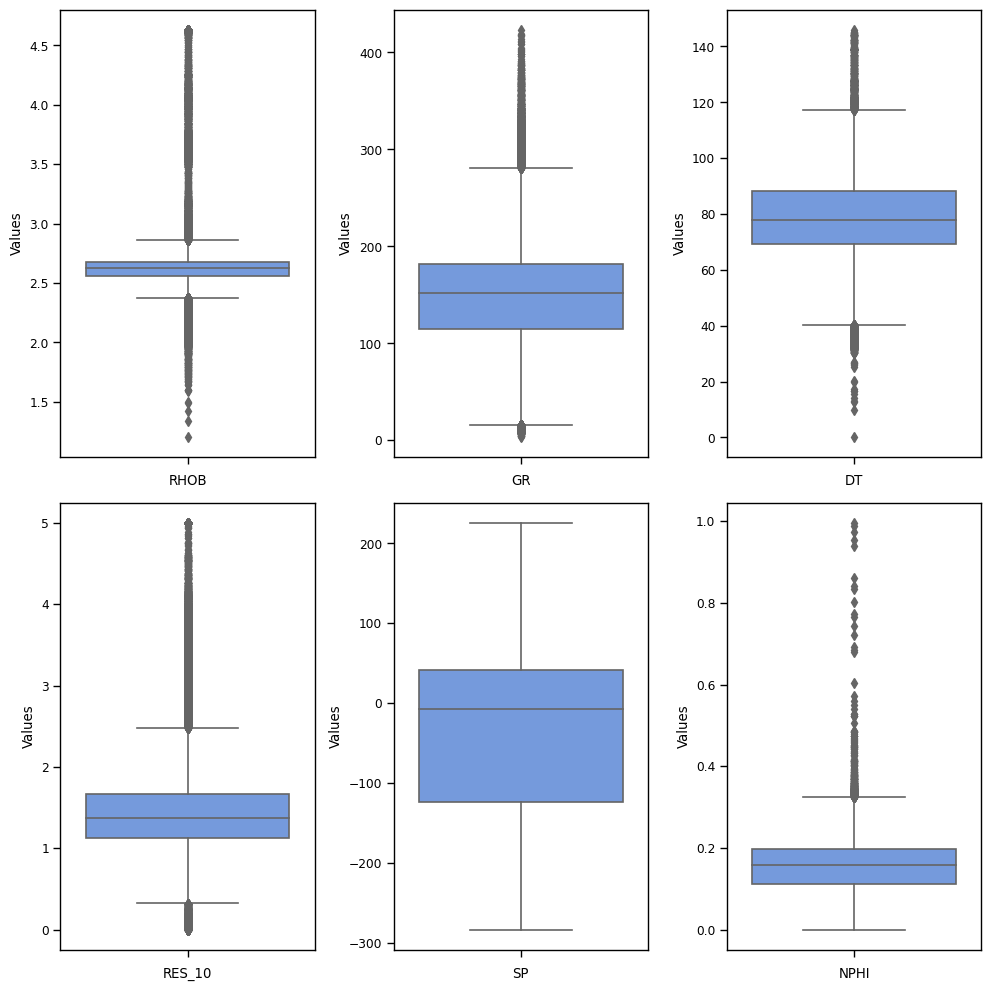

In [23]:
# histogram of well-logs
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
sns.set_context('paper')

sns.boxplot(data=beetaloo, y='RHOB', color='cornflowerblue', ax=axes[0,0])
axes[0,0].set_xlabel('RHOB')
axes[0,0].set_ylabel('Values')

sns.boxplot(data=beetaloo, y='GR', color='cornflowerblue', ax=axes[0,1])
axes[0,1].set_xlabel('GR')
axes[0,1].set_ylabel('Values')


sns.boxplot(data=beetaloo, y='DT', color='cornflowerblue', ax=axes[0,2])
axes[0,2].set_xlabel('DT')
axes[0,2].set_ylabel('Values')


sns.boxplot(data=beetaloo, y='RES_10', color='cornflowerblue', ax=axes[1,0])
axes[1,0].set_xlabel('RES_10')
axes[1,0].set_ylabel('Values')

sns.boxplot(data=beetaloo, y='SP', color='cornflowerblue', ax=axes[1,1])
axes[1,1].set_xlabel('SP')
axes[1,1].set_ylabel('Values')


sns.boxplot(data=beetaloo, y='NPHI', color='cornflowerblue', ax=axes[1,2])
axes[1,2].set_xlabel('NPHI')
axes[1,2].set_ylabel('Values')

plt.tight_layout()
plt.show()

### Missing Values Analysis

In [24]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']

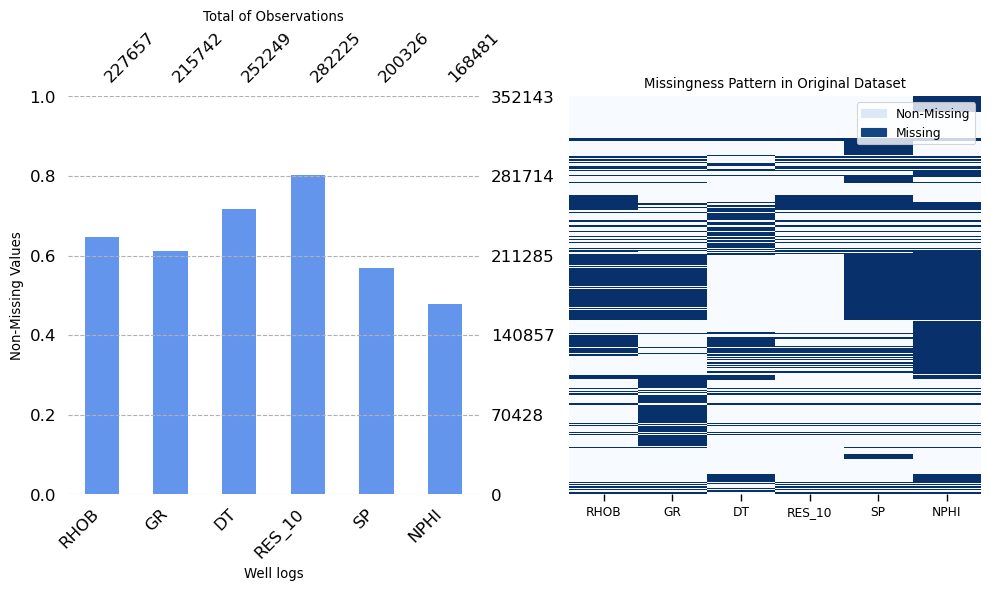

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.set_context('paper')
# missingness bar plot
msno.bar(df=beetaloo[well_logs], ax=axes[0], fontsize=12, color='cornflowerblue')
axes[0].set_xlabel('Well logs')
axes[0].set_ylabel('Non-Missing Values')
axes[0].set_title('Total of Observations')
axes[0].grid(axis='y', linestyle='--')

# missingness pattern in well-logs
sns.heatmap(beetaloo[well_logs].isna(), yticklabels=False, cbar=False, cmap='Blues', ax=axes[1])
axes[1].legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in ["#DBE9F6", "#124683"]], ['Non-Missing', 'Missing'], frameon=True)
axes[1].set_title('Missingness Pattern in Original Dataset')
plt.tight_layout()
plt.show()

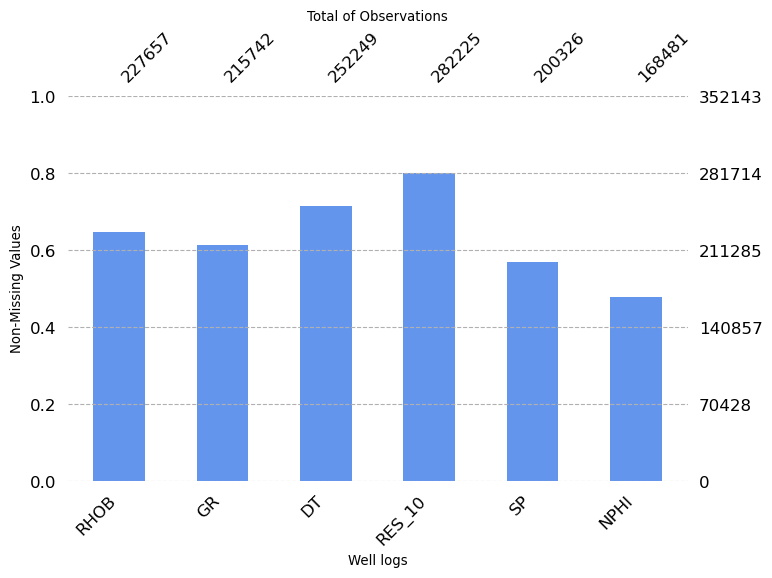

In [20]:
# missingness bar plot
fig, axes = plt.subplots(figsize=(8, 5))

msno.bar(df=beetaloo[well_logs], ax=axes, fontsize=12, color='cornflowerblue')

axes.set_xlabel('Well logs')
axes.set_ylabel('Non-Missing Values')
axes.set_title('Total of Observations')
axes.grid(axis='y', linestyle='--')

plt.show()

In [21]:
# check for missing values per column
round(beetaloo[well_logs].isna().sum() / beetaloo.shape[0], 2)

RHOB      0.35
GR        0.39
DT        0.28
RES_10    0.20
SP        0.43
NPHI      0.52
dtype: float64

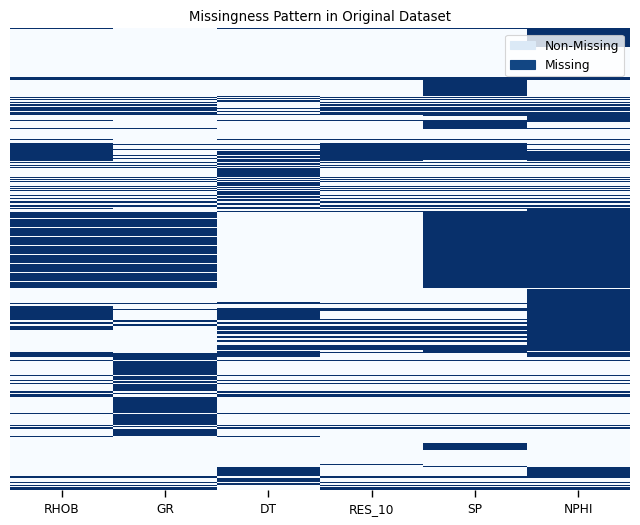

In [20]:
# missingness pattern in well-logs
plt.figure(figsize=(8, 6))
sns.set_context('paper')
axes = sns.heatmap(beetaloo[well_logs].isna(), yticklabels=False, 
                 cbar=False, cmap='Blues')
axes.legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in ["#DBE9F6", "#124683"]], ['Non-Missing', 'Missing'], frameon=True)
axes.set_title('Missingness Pattern in Original Dataset')
plt.show()

#### Correlation Analysis

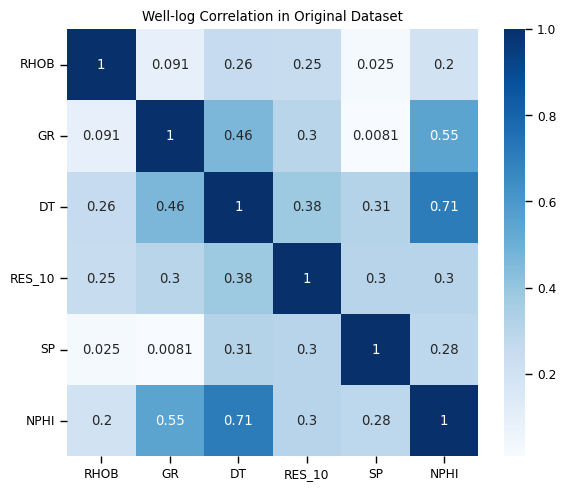

In [22]:
# correlation
beetaloo_corr = beetaloo[well_logs].corr().abs()
fig = plt.figure(figsize=(6, 5))
sns.set_context('paper')
sns.heatmap(beetaloo_corr, cmap='Blues', annot=True)
plt.title('Well-log Correlation in Original Dataset')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
beetaloo_corr

,RHOB,GR,DT,RES_10,SP,NPHI
RHOB,1.000000,0.091392,0.258958,0.249614,0.024688,0.199476
GR,0.091392,1.000000,0.462176,0.300205,0.008142,0.550403
DT,0.258958,0.462176,1.000000,0.380785,0.311446,0.712413
RES_10,0.249614,0.300205,0.380785,1.000000,0.303276,0.303262
SP,0.024688,0.008142,0.311446,0.303276,1.000000,0.283767
NPHI,0.199476,0.550403,0.712413,0.303262,0.283767,1.000000


#### Pairplot of Well logs

<Figure size 800x600 with 0 Axes>

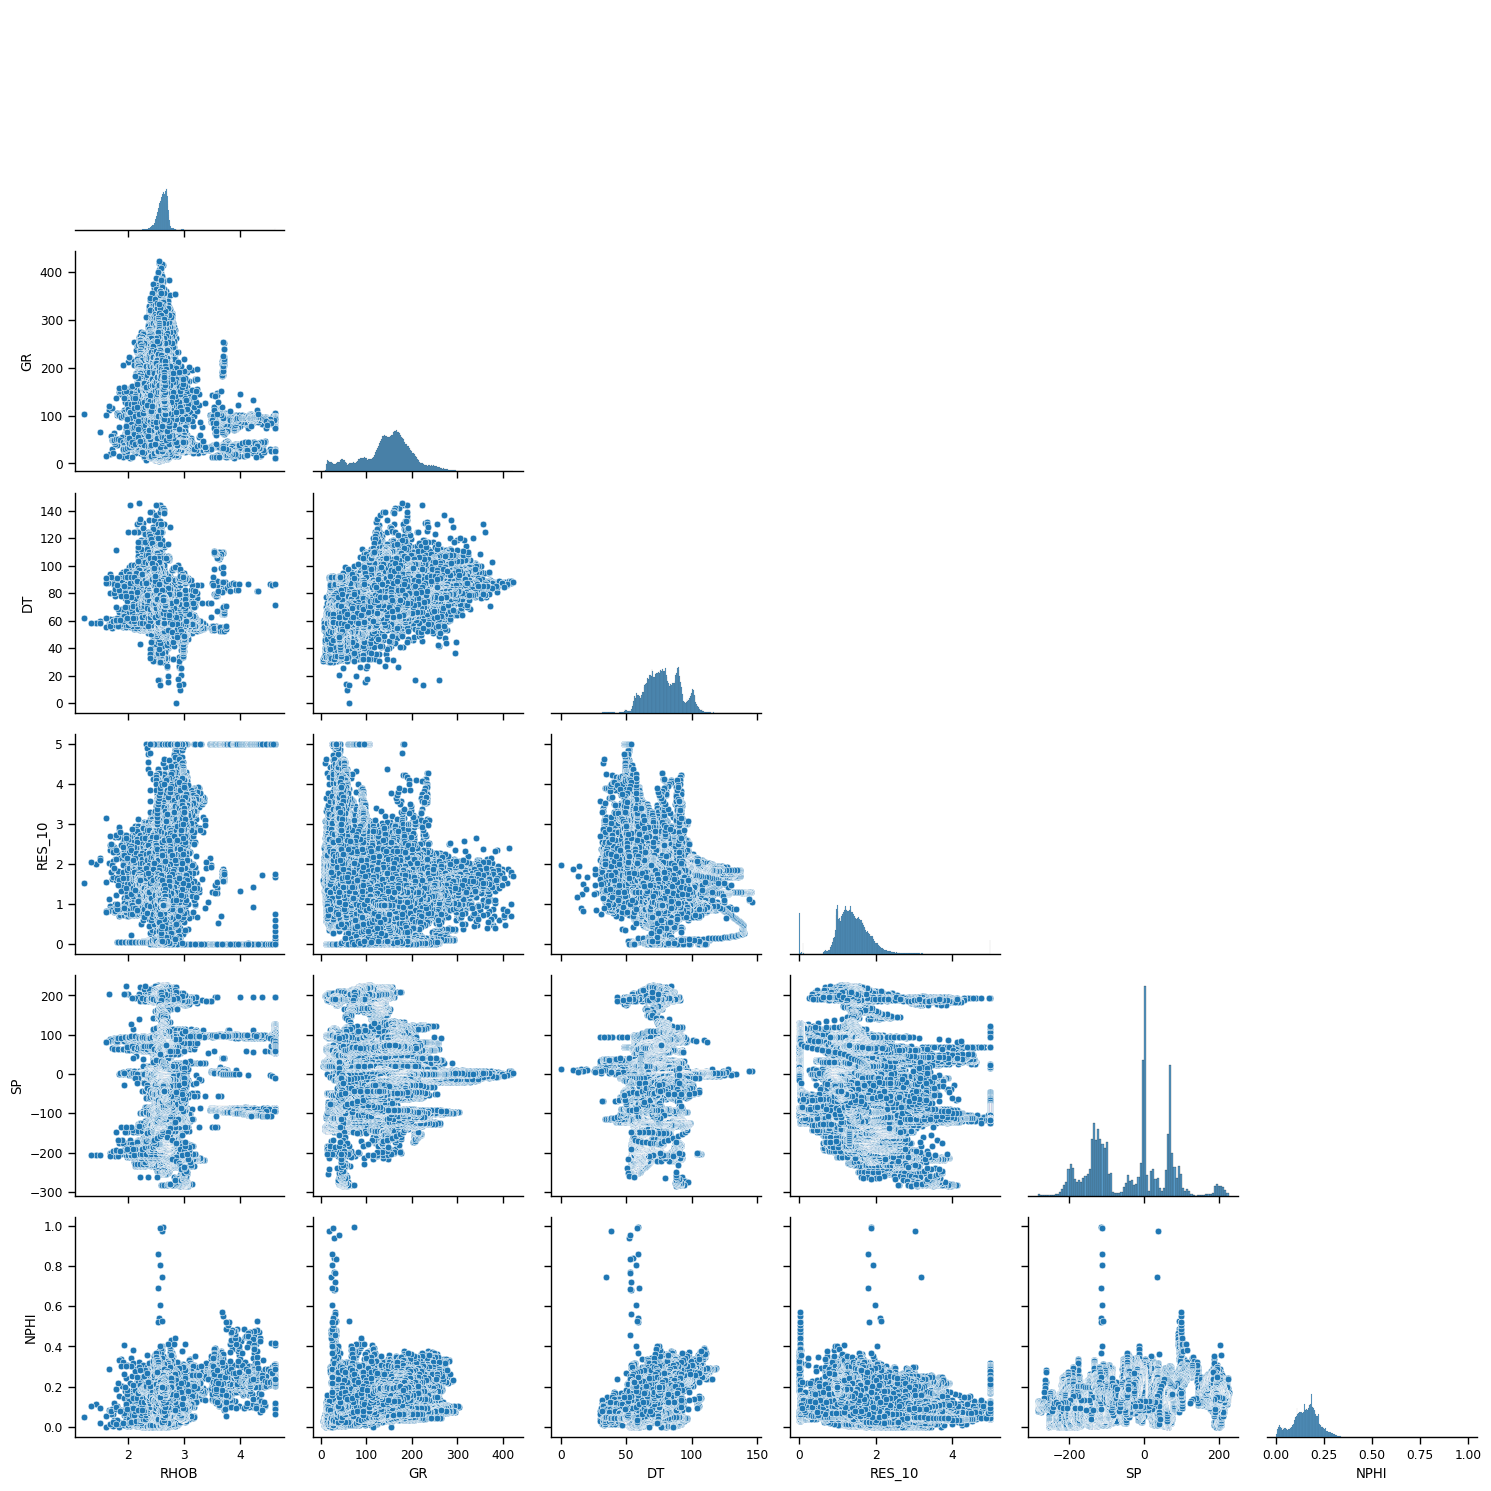

In [22]:
# pairplot of well-logs
fig = plt.figure(figsize=(8, 6))
sns.set_context('paper')
sns.pairplot(beetaloo[well_logs], corner=True)
plt.tight_layout()
plt.show()

## 1.5. Feature Engineering and Selection

In [23]:
# label encoding for well id
well_encoder = LabelEncoder()
beetaloo['WELL'] = well_encoder.fit_transform(beetaloo['WELL_ID'])

# label encoding for stratigraphy
strat_encoder = LabelEncoder()
beetaloo['STRAT_ENCODED'] = strat_encoder.fit_transform(beetaloo['STRAT'])

In [24]:
# columns
beetaloo.columns

Index(['WELL_ID', 'Y', 'X', 'DEPTH', 'RHOB', 'GR', 'DT', 'RES', 'SP', 'NPHI',
       'LITHO', 'STRAT', 'LATITUDE', 'LONGITUDE', 'RES_10', 'WELL',
       'STRAT_ENCODED'],
      dtype='object')

In [25]:
# feature selection
selected_features = ['WELL', 'X', 'Y', 'DEPTH', 
                     'RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI',
                     'STRAT_ENCODED']

# 2. Data Splitting

In [26]:
# copy of the dataset for modeling
data_ml = beetaloo[selected_features].copy()

In [27]:
# well test selection
test_wells = well_encoder.transform(['Tarlee_2', 'Beetaloo_W1', 'Friendship_1', 'Burdo_1', 'McManus_1', 'Amungee_NW1'])

# mask for test well
test_mask = data_ml['WELL'].isin(test_wells)

# column to identify train and test wells
data_ml['train_test'] = 'Train'
data_ml.loc[test_mask, 'train_test'] = 'Test'

# fraction of data
train_fraction = data_ml[data_ml['train_test'] == 'Train'].shape[0] / data_ml.shape[0]
test_fraction = data_ml[data_ml['train_test'] == 'Test'].shape[0] / data_ml.shape[0]
print(f"Fraction of data in train set: {train_fraction:.2f}")
print(f"Fraction of data in test set: {test_fraction:.2f}")
print(f"Total number of samples in dataset: {data_ml.shape[0]}")

Fraction of data in train set: 0.83
Fraction of data in test set: 0.17
Total number of samples in dataset: 352143


In [28]:
# create train and test sets
train = data_ml[~test_mask].copy()
test = data_ml[test_mask].copy()

### Evaluation of Training and Test Sets

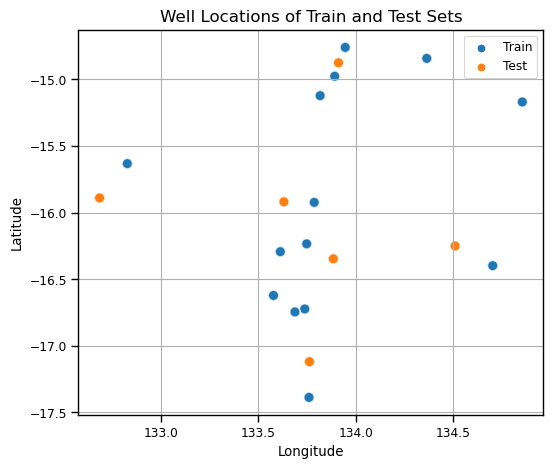

In [29]:
# plotting well locations for train and test sets
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data_ml, x='X', y='Y', hue='train_test', alpha=0.5, s=50)
plt.title('Well Locations of Train and Test Sets', fontsize=12)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.legend()
plt.show()

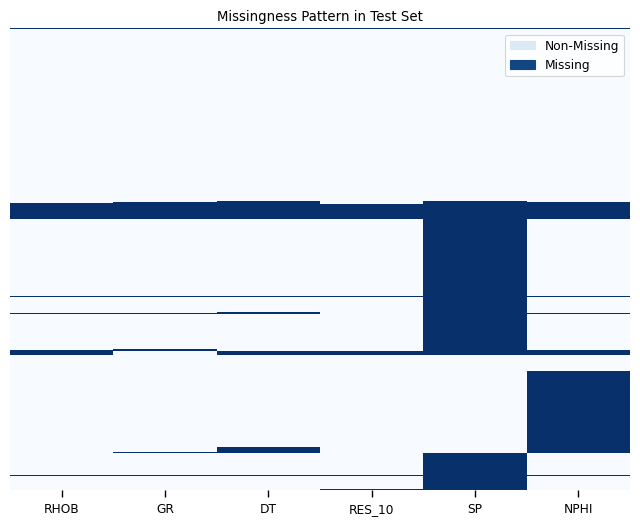

In [30]:
# missingness pattern for the test set
plt.figure(figsize=(8, 6))
sns.set_context('paper')
axes = sns.heatmap(test[well_logs].isna(), yticklabels=False, 
                 cbar=False, cmap='Blues')
axes.set_title('Missingness Pattern in Test Set')
axes.legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in ["#DBE9F6", "#124683"]], ['Non-Missing', 'Missing'], frameon=True)
plt.show()

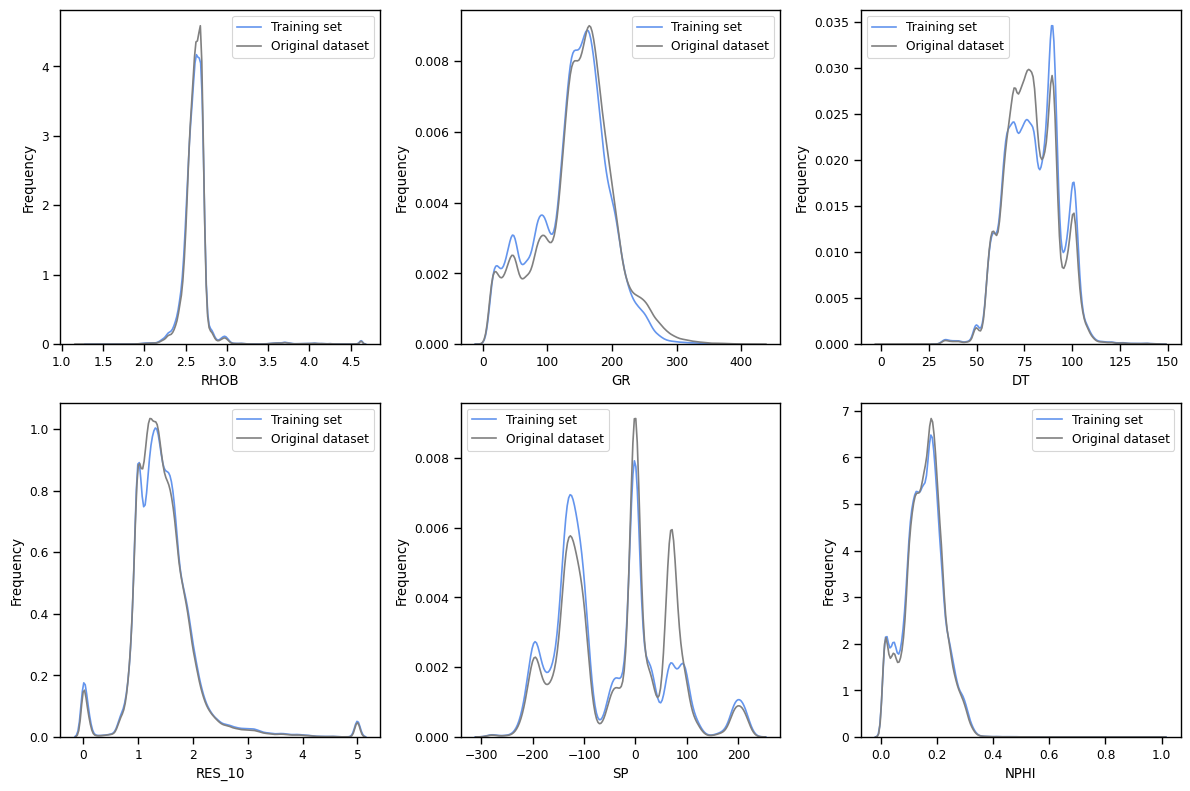

In [31]:
# histogram of well-logs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sns.set_context('paper')

sns.kdeplot(train['RHOB'], color='cornflowerblue', ax=axes[0,0], label='Training set')
sns.kdeplot(beetaloo['RHOB'], color='grey', ax=axes[0,0], label='Original dataset')
axes[0,0].set_xlabel('RHOB')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()


sns.kdeplot(train['GR'], color='cornflowerblue', ax=axes[0,1], label='Training set')
sns.kdeplot(beetaloo['GR'], color='grey', ax=axes[0,1], label='Original dataset')
axes[0,1].set_xlabel('GR')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

sns.kdeplot(train['DT'], color='cornflowerblue', ax=axes[0,2], label='Training set')
sns.kdeplot(beetaloo['DT'], color='grey', ax=axes[0,2], label='Original dataset')
axes[0,2].set_xlabel('DT')
axes[0,2].set_ylabel('Frequency')
axes[0,2].legend()

sns.kdeplot(train['RES_10'], color='cornflowerblue', ax=axes[1,0], label='Training set')
sns.kdeplot(beetaloo['RES_10'], color='grey', ax=axes[1,0], label='Original dataset')
axes[1,0].set_xlabel('RES_10')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

sns.kdeplot(train['SP'], color='cornflowerblue', ax=axes[1,1], label='Training set')
sns.kdeplot(beetaloo['SP'], color='grey', ax=axes[1,1], label='Original dataset')
axes[1,1].set_xlabel('SP')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

sns.kdeplot(train['NPHI'], color='cornflowerblue', ax=axes[1,2], label='Training set')
sns.kdeplot(beetaloo['NPHI'], color='grey', ax=axes[1,2], label='Original dataset')
axes[1,2].set_xlabel('NPHI')
axes[1,2].set_ylabel('Frequency')
axes[1,2].legend()

plt.tight_layout()
plt.show()

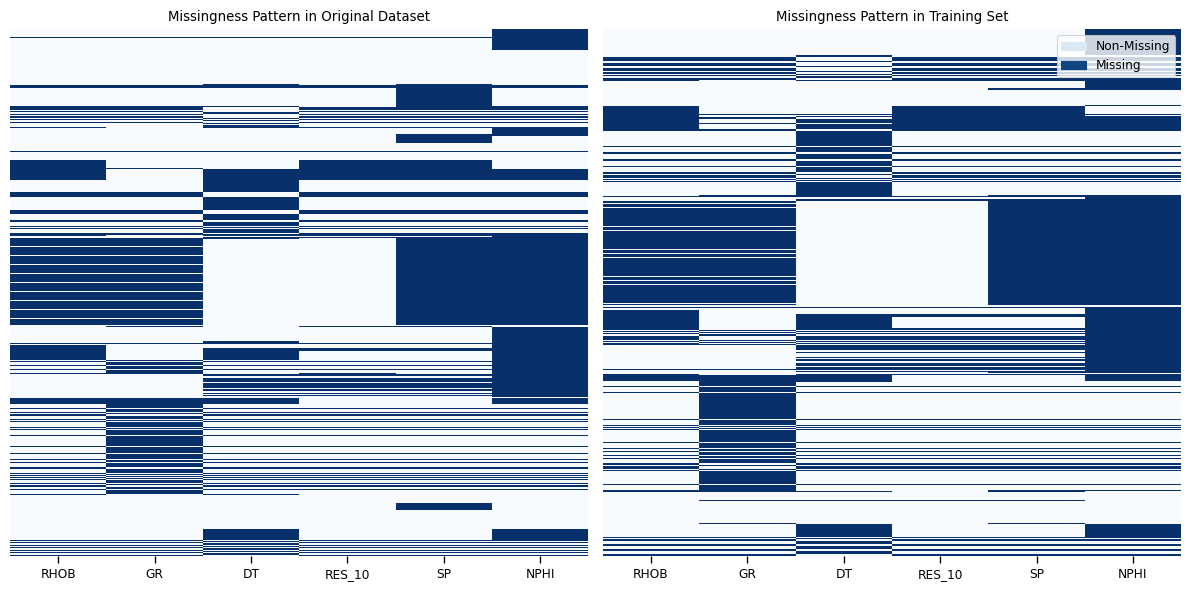

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context('paper')

sns.heatmap(beetaloo[well_logs].isna(), yticklabels=False, cbar=False, cmap='Blues', ax=axes[0])
axes[0].set_title('Missingness Pattern in Original Dataset')


sns.heatmap(train[well_logs].isna(), yticklabels=False, cbar=False, cmap='Blues', ax=axes[1])
axes[1].set_title('Missingness Pattern in Training Set')

axes[1].legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in ["#DBE9F6", "#124683"]], 
          ['Non-Missing', 'Missing'], frameon=True)

plt.tight_layout()
plt.show()

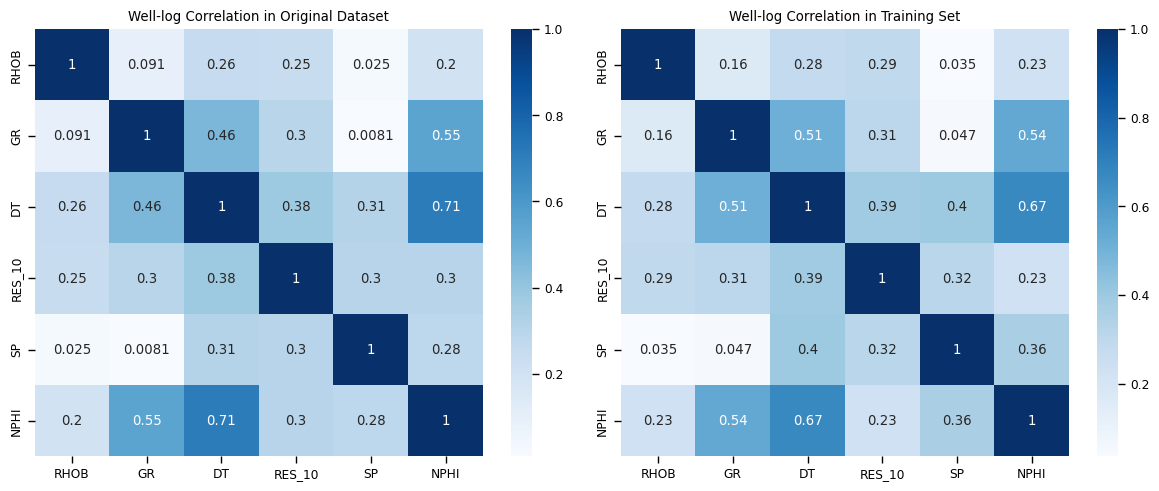

In [33]:
# correlation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.set_context('paper')

original_corr = beetaloo[well_logs].corr().abs()
sns.heatmap(original_corr, cmap='Blues', annot=True, ax=axes[0])
axes[0].set_title('Well-log Correlation in Original Dataset')

train_corr = train[well_logs].corr().abs()
sns.heatmap(train_corr, cmap='Blues', annot=True, ax=axes[1])
axes[1].set_title('Well-log Correlation in Training Set')

plt.tight_layout()
plt.show()

# 3. Model Training

## 3.1. Input Values

In [34]:
# copy of train and test sets
X_train = train.copy()
X_test = test.copy()

In [35]:
# features to impute 
features_mice = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI', 'STRAT_ENCODED']
imputed_cols = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']

In [36]:
# list with all combinations of well-logs for each well
unique_wells = X_train['WELL'].unique()
combinations = []
for well in unique_wells:
    for feature in imputed_cols:
        # only for well-logs that are not completely NaN
        if not X_train.loc[X_train['WELL'] == well, feature].isna().all():
            combinations.append((well, feature))
            
print('Number of Combinations:', len(combinations))

Number of Combinations: 119


In [37]:
# function to impute NaN values using iterative imputer (MICE)
def impute(train_data, cols_imp, model):
    mice = IterativeImputer(estimator=model, initial_strategy='mean' , random_state=17, max_iter=10, tol=0.01)
    mice.fit(train_data[cols_imp])
    imputed_train = mice.transform(train_data[cols_imp])
    return imputed_train, mice

## 3.2. Hyperparameter Tuning

In [38]:
def tuning_cv(X_train, model, param_grid, well_logs, cols_imp, combinations, n_splits, n_jobs):
    """
    Cross-Validation for Hyperparameter Tuning using MICE
    
    Parameters
    -------------------------------------------------------------------------------------------
        X_train: (pd.DataFrame) 
            Training data
        
        model: (model object for imputation)
            Model (e.g., KNeighborsRegressor, BayesianRidge, RF, XGBoost)
            
        param_grid: (dict)
            Dictionary of hyperparameter grids for the model
            
        well_logs: (list)
            List of well logs to evaluate
            
        cols_imp: (list)
            List of columns to impute
            
        combinations: (list)
            List of well and feature combinations
            
        n_splits: (int)
            Number of cross-validation splits
            
        n_jobs: (int)
            Number of jobs to run in parallel during imputation
    
    Returns
    -------------------------------------------------------------------------------------------
        results_df: (pd.DataFrame)
            DataFrame containing the evaluation results
            
        final_time: (float)
            Execution time in seconds
    """   
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    
    results = {}
    
    start_time = time.time()  
    
    for params in ParameterGrid(param_grid):
        for i, (train_index, val_index) in enumerate(kf.split(combinations)):
            
            # train and validations sets
            train_combinations = [combinations[i] for i in train_index]
            validation_combinations = [combinations[i] for i in val_index]
            
            # copy of the data to work with
            data_train = X_train.copy()
            
            # set values to NaN in the data to impute using the validation combinations
            for well_id, feature_name in validation_combinations:
                data_train.loc[data_train['WELL']==well_id, feature_name] = np.nan
                
                
            # scale the data for training with NaN 
            scaler = MinMaxScaler()
            scaler.fit(data_train[cols_imp])
            X_training_scaled = scaler.transform(data_train[cols_imp])
            X_training_scaled_df = pd.DataFrame(X_training_scaled, 
                                                columns=cols_imp,
                                                index=X_train.index)
            
            # scale the orignal training data
            X_training_original_scale = scaler.transform(X_train[cols_imp])        
            X_training_original_df = pd.DataFrame(X_training_original_scale, 
                                                  columns=cols_imp,
                                                  index=X_train.index)
            X_training_original_df['WELL'] = X_train['WELL']
                
            # impute NaN values using iterative imputer
            if model == KNeighborsRegressor:
                X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                                   cols_imp=cols_imp,
                                                   model=model(**params, n_jobs=n_jobs))
                
            elif model == BayesianRidge:
                X_training_imp, imp_model = impute(train_data=X_training_scaled_df,
                                                   cols_imp=cols_imp,
                                                   model=model(**params))
                
            else:
                X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                                   cols_imp=cols_imp,
                                                   model=model(**params, random_state=17, n_jobs=n_jobs))


            X_training_imp_scaled = pd.DataFrame(X_training_imp, columns=cols_imp, index=X_train.index)
            
            
            # evaluate the imputation using validation combinations
            mse_results = {col: [] for col in well_logs}
            
            for well_id, feature_name in validation_combinations:
                original = X_training_original_df.loc[X_training_original_df['WELL']==well_id, feature_name].dropna()
                original_index = list(original.index.values)
                
                imputed = X_training_imp_scaled.loc[original_index, feature_name]
                
                mse = mean_squared_error(original, imputed)
                mse_results[feature_name].append(mse)

            mean_mse = {col: np.mean(mse_results[col]) for col in mse_results}
             
            param_name = tuple(f"{k}={v}" for k, v in params.items())
            for col in well_logs:
                key = (param_name, col)
                results[key] = {'MSE': mean_mse[col]}
    
    # final results
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'level_0': 'PARAMETERS', 'level_1': 'WELL_LOGS'})
    
    
    end_time = time.time()  # record end time
    final_time = end_time - start_time  # final time
    
    return results_df, final_time

In [39]:
def print_tuning_results(time_print, df_result_print, top_n=10):

    print('Tuning Time: {:.2f} seconds\n'.format(time_print))
    
    top_results = df_result_print.groupby('PARAMETERS')['MSE'].mean().sort_values().head(top_n)
    print('Top MSE Results:')
    
    for tuning_parameter, tuning_mse_result in top_results.items():
        print('MSE: {:.4f}, Parameters: {}'.format(tuning_mse_result, tuning_parameter))

### KNeighborsRegressor

In [40]:
param_grid_knr = {'n_neighbors': [5, 10, 15],  # number of neighbors to use [default=5]
                  'leaf_size': [30, 50, 100]  # leaf size passed to BallTree or KDTree [default=30]
                 }

In [41]:
results_knr, time_knr = tuning_cv(X_train=X_train,
                                  model=KNeighborsRegressor, 
                                  param_grid=param_grid_knr,
                                  well_logs=imputed_cols,
                                  cols_imp=features_mice, 
                                  combinations=combinations, 
                                  n_splits=5,
                                  n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

In [42]:
print_tuning_results(time_knr, results_knr, top_n=20)

Tuning Time: 12468.07 seconds

Top MSE Results:
MSE: 0.0139, Parameters: ('leaf_size=50', 'n_neighbors=5')
MSE: 0.0139, Parameters: ('leaf_size=30', 'n_neighbors=5')
MSE: 0.0140, Parameters: ('leaf_size=100', 'n_neighbors=5')
MSE: 0.0141, Parameters: ('leaf_size=30', 'n_neighbors=10')
MSE: 0.0141, Parameters: ('leaf_size=100', 'n_neighbors=10')
MSE: 0.0141, Parameters: ('leaf_size=50', 'n_neighbors=10')
MSE: 0.0145, Parameters: ('leaf_size=30', 'n_neighbors=15')
MSE: 0.0145, Parameters: ('leaf_size=100', 'n_neighbors=15')
MSE: 0.0145, Parameters: ('leaf_size=50', 'n_neighbors=15')


### BayesianRidge

In [43]:
param_grid_br = {'n_iter': [200, 300, 400],       # maximum number of iterations [default=300]
                 'alpha_1': [1e-6, 1e-5, 1e-4],   # precision of the noise [default=1e-6]
                 'alpha_2': [1e-6, 1e-5, 1e-4],   # precision of the noise [default=1e-6]
                 'lambda_1': [1e-6, 1e-5, 1e-4],  # precision of the weights [default=1e-6]
                 'lambda_2': [1e-6, 1e-5, 1e-4]   # precision of the weights [default=1e-6]
                }

In [44]:
results_br, time_br = tuning_cv(X_train=X_train,
                                model=BayesianRidge, 
                                param_grid=param_grid_br,
                                well_logs=imputed_cols,
                                cols_imp=features_mice, 
                                combinations=combinations, 
                                n_splits=5,
                                n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

In [45]:
print_tuning_results(time_br, results_br, top_n=10)

Tuning Time: 4607.77 seconds

Top MSE Results:
MSE: 0.0181, Parameters: ('alpha_1=0.0001', 'alpha_2=0.0001', 'lambda_1=1e-06', 'lambda_2=1e-06', 'n_iter=200')
MSE: 0.0181, Parameters: ('alpha_1=0.0001', 'alpha_2=0.0001', 'lambda_1=1e-06', 'lambda_2=1e-06', 'n_iter=400')
MSE: 0.0181, Parameters: ('alpha_1=0.0001', 'alpha_2=0.0001', 'lambda_1=1e-06', 'lambda_2=1e-06', 'n_iter=300')
MSE: 0.0181, Parameters: ('alpha_1=1e-05', 'alpha_2=0.0001', 'lambda_1=1e-06', 'lambda_2=1e-06', 'n_iter=400')
MSE: 0.0181, Parameters: ('alpha_1=1e-05', 'alpha_2=0.0001', 'lambda_1=1e-06', 'lambda_2=1e-06', 'n_iter=300')
MSE: 0.0181, Parameters: ('alpha_1=1e-05', 'alpha_2=0.0001', 'lambda_1=1e-06', 'lambda_2=1e-06', 'n_iter=200')
MSE: 0.0181, Parameters: ('alpha_1=1e-06', 'alpha_2=0.0001', 'lambda_1=1e-06', 'lambda_2=1e-06', 'n_iter=400')
MSE: 0.0181, Parameters: ('alpha_1=1e-06', 'alpha_2=0.0001', 'lambda_1=1e-06', 'lambda_2=1e-06', 'n_iter=300')
MSE: 0.0181, Parameters: ('alpha_1=1e-06', 'alpha_2=0.0001', '

### RandomForestRegressor

In [46]:
param_grid_rf = {'max_depth': [6, 10],             # maximum depth of the trees [default=None]
                 'min_samples_split': [2, 10],     # minimum number of samples required to split an internal node [default=2]
                 'min_samples_leaf': [1, 5]        # minimum number of samples required to be at a leaf node [default=1]
                }

In [47]:
results_rf, time_rf = tuning_cv(X_train=X_train,
                                model=RandomForestRegressor, 
                                param_grid=param_grid_rf,
                                well_logs=imputed_cols,
                                cols_imp=features_mice, 
                                combinations=combinations, 
                                n_splits=5,
                                n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

In [48]:
print_tuning_results(time_rf, results_rf, top_n=20)

Tuning Time: 14131.66 seconds

Top MSE Results:
MSE: 0.0126, Parameters: ('max_depth=10', 'min_samples_leaf=1', 'min_samples_split=10')
MSE: 0.0126, Parameters: ('max_depth=10', 'min_samples_leaf=1', 'min_samples_split=2')
MSE: 0.0131, Parameters: ('max_depth=10', 'min_samples_leaf=5', 'min_samples_split=10')
MSE: 0.0131, Parameters: ('max_depth=10', 'min_samples_leaf=5', 'min_samples_split=2')
MSE: 0.0136, Parameters: ('max_depth=6', 'min_samples_leaf=1', 'min_samples_split=10')
MSE: 0.0143, Parameters: ('max_depth=6', 'min_samples_leaf=5', 'min_samples_split=10')
MSE: 0.0143, Parameters: ('max_depth=6', 'min_samples_leaf=5', 'min_samples_split=2')
MSE: 0.0154, Parameters: ('max_depth=6', 'min_samples_leaf=1', 'min_samples_split=2')


### XGBRegressor

In [49]:
param_grid_xgb = {'max_depth': [6, 7, 10],  # maximum depth of a tree [default=6]
                  'reg_lambda': [0, 2]      # L2 regularization term on weights [default=1]
                 }

In [50]:
results_xgb, time_xgb = tuning_cv(X_train=X_train,
                                  model=XGBRegressor, 
                                  param_grid=param_grid_xgb,
                                  well_logs=imputed_cols,
                                  cols_imp=features_mice, 
                                  combinations=combinations,
                                  n_splits=5,
                                  n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

In [51]:
print_tuning_results(time_xgb, results_xgb, top_n=20)

Tuning Time: 11027.36 seconds

Top MSE Results:
MSE: 0.0117, Parameters: ('max_depth=7', 'reg_lambda=2')
MSE: 0.0117, Parameters: ('max_depth=6', 'reg_lambda=2')
MSE: 0.0119, Parameters: ('max_depth=7', 'reg_lambda=0')
MSE: 0.0128, Parameters: ('max_depth=6', 'reg_lambda=0')
MSE: 0.0131, Parameters: ('max_depth=10', 'reg_lambda=2')
MSE: 0.0138, Parameters: ('max_depth=10', 'reg_lambda=0')


## 3.3. Model Training with the best Hyperparameters

In [52]:
def cv_training(X_train, model, param_grid, well_logs, cols_imp, combinations, n_splits, n_jobs):
    """
    Cross-Validation for MICE and Model Evaluation
    
    Parameters
    ---------------------------------------------------------------------------------------------
        X_train: (pd.DataFrame) 
            Training data
        
        model: (model object for imputation)
            Model (e.g., KNeighborsRegressor, BayesianRidge, RF, XGBoost)
            
        param_grid: (dict)
            Dictionary of hyperparameter grids for the model
            
        well_logs: (list)
            List of well logs to evaluate
            
        cols_imp: (list)
            List of columns to impute
            
        combinations: (list)
            List of well and feature combinations
            
        n_splits: (int)
            Number of cross-validation splits
            
        n_jobs: (int)
            Number of jobs to run in parallel during imputation
    
    Returns
    ---------------------------------------------------------------------------------------------
        results: (dict)
            Dictionary containing the evaluation results for each well log
            
        final_time: (float)
            Execution time in seconds
    """  
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    
    r2_results = {col: [] for col in well_logs}
    mae_results = {col: [] for col in well_logs}
    mse_results = {col: [] for col in well_logs}
    
    start_time = time.time()  # record start time
      
    for i, (train_index, val_index) in enumerate(kf.split(combinations)):

        # train and validations sets
        train_combinations = [combinations[i] for i in train_index]
        validation_combinations = [combinations[i] for i in val_index]

        # copy of the data to work with
        data_train = X_train.copy()

        # set values to NaN in the data to impute using the validation combinations
        for well_id, feature_name in validation_combinations:
            data_train.loc[data_train['WELL']==well_id, feature_name] = np.nan


        # scale the data for training with NaN 
        scaler = MinMaxScaler()
        scaler.fit(data_train[cols_imp])
        X_training_scaled = scaler.transform(data_train[cols_imp])
        X_training_scaled_df = pd.DataFrame(X_training_scaled, 
                                            columns=cols_imp,
                                            index=X_train.index)

        # scale the orignal training data
        X_training_original_scale = scaler.transform(X_train[cols_imp])        
        X_training_original_df = pd.DataFrame(X_training_original_scale, 
                                              columns=cols_imp,
                                              index=X_train.index)
        X_training_original_df['WELL'] = X_train['WELL']
        
        
        # impute NaN values using iterative imputer
        if model == KNeighborsRegressor:
            X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                               cols_imp=cols_imp,
                                               model=model(**param_grid, n_jobs=n_jobs))

        elif model == BayesianRidge:
            X_training_imp, imp_model = impute(train_data=X_training_scaled_df,
                                               cols_imp=cols_imp,
                                               model=model(**param_grid))

        else:
            X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                               cols_imp=cols_imp,
                                               model=model(**param_grid, random_state=17, n_jobs=n_jobs))

        X_training_imp_scaled = pd.DataFrame(X_training_imp, columns=cols_imp, index=X_train.index)

        # evaluate the imputation using validation combinations
        for well_id, feature_name in validation_combinations:         
            original = X_training_original_df.loc[X_training_original_df['WELL']==well_id, feature_name].dropna()
            original_index = list(original.index.values)

            imputed = X_training_imp_scaled.loc[original_index, feature_name]            

            r2 = r2_score(original, imputed)
            r2_results[feature_name].append(r2)
            
            mae = mean_absolute_error(original, imputed)
            mae_results[feature_name].append(mae)
            
            mse = mean_squared_error(original, imputed)
            mse_results[feature_name].append(mse)
    
    results = {'R2': r2_results, 'MAE': mae_results, 'MSE': mse_results}
    
    end_time = time.time()  # record end time
    final_time = end_time - start_time  # final time
    
    return results, final_time

In [53]:
def boxplot_results(results, well_logs_plot):
    
    metrics = list(results.keys())
    
    fig, axes = plt.subplots(nrows=len(metrics), ncols=len(well_logs_plot), figsize=(15, 10))
    
    for i, metric in enumerate(metrics):
        for j, log in enumerate(well_logs_plot):
            
            axes[i,j].boxplot(results[metric][log])
            axes[i,j].set_xlabel(log)
            axes[i,j].set_xticklabels([])
            
            if j == 0:
                axes[i,j].set_ylabel(metric)
        
    plt.tight_layout()
    plt.show()

In [54]:
def training_model(X_train, model, param_grid, well_logs, cols_imp, n_splits, n_jobs):
    """
    Training Model with MICE
    
    Parameters
    ----------------------------------------------------------------------------------
        X_train: (pd.DataFrame) 
            Training data
        
        model: (model object for imputation)
            Model (e.g., KNeighborsRegressor, BayesianRidge, RF, XGBoost)
            
        param_grid: (dict)
            Dictionary of hyperparameters for the model
            
        well_logs: (list)
            List of well logs to evaluate
            
        cols_imp: (list)
            List of columns to impute
            
        n_splits: (int)
            Number of cross-validation splits
            
        n_jobs: (int)
            Number of jobs to run in parallel during imputation
    
    Returns
    ----------------------------------------------------------------------------------
        scaler: (object)
            MinMaxScaler object fitted on the imputed training data
            
        imp_model: (object)
            Trained imputation model
    """
    # copy of the data to work with
    data_train = X_train.copy()

    # scale the data for training
    scaler = MinMaxScaler()
    scaler.fit(data_train[cols_imp])
    X_training_scaled = scaler.transform(data_train[cols_imp])
    X_training_scaled_df = pd.DataFrame(X_training_scaled, 
                                        columns=cols_imp,
                                        index=X_train.index)

    # impute NaN values using iterative imputer
    if model == KNeighborsRegressor:
        X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                           cols_imp=cols_imp,
                                           model=model(**param_grid, n_jobs=n_jobs))

    elif model == BayesianRidge:
        X_training_imp, imp_model = impute(train_data=X_training_scaled_df,
                                           cols_imp=cols_imp,
                                           model=model(**param_grid))

    else:
        X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                           cols_imp=cols_imp,
                                           model=model(**param_grid, random_state=17, n_jobs=n_jobs))

    return scaler, imp_model

### KNeighborsRegressor

In [55]:
param_grid_knr = {}

In [56]:
train_results_knr, train_time_knr = cv_training(X_train=X_train,
                                                model=KNeighborsRegressor, 
                                                param_grid=param_grid_knr,
                                                well_logs=imputed_cols,
                                                cols_imp=features_mice, 
                                                combinations=combinations, 
                                                n_splits=5,
                                                n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [57]:
print('Cross-Validation Time: {:.2f} seconds \n'.format(train_time_knr))

Cross-Validation Time: 868.58 seconds 



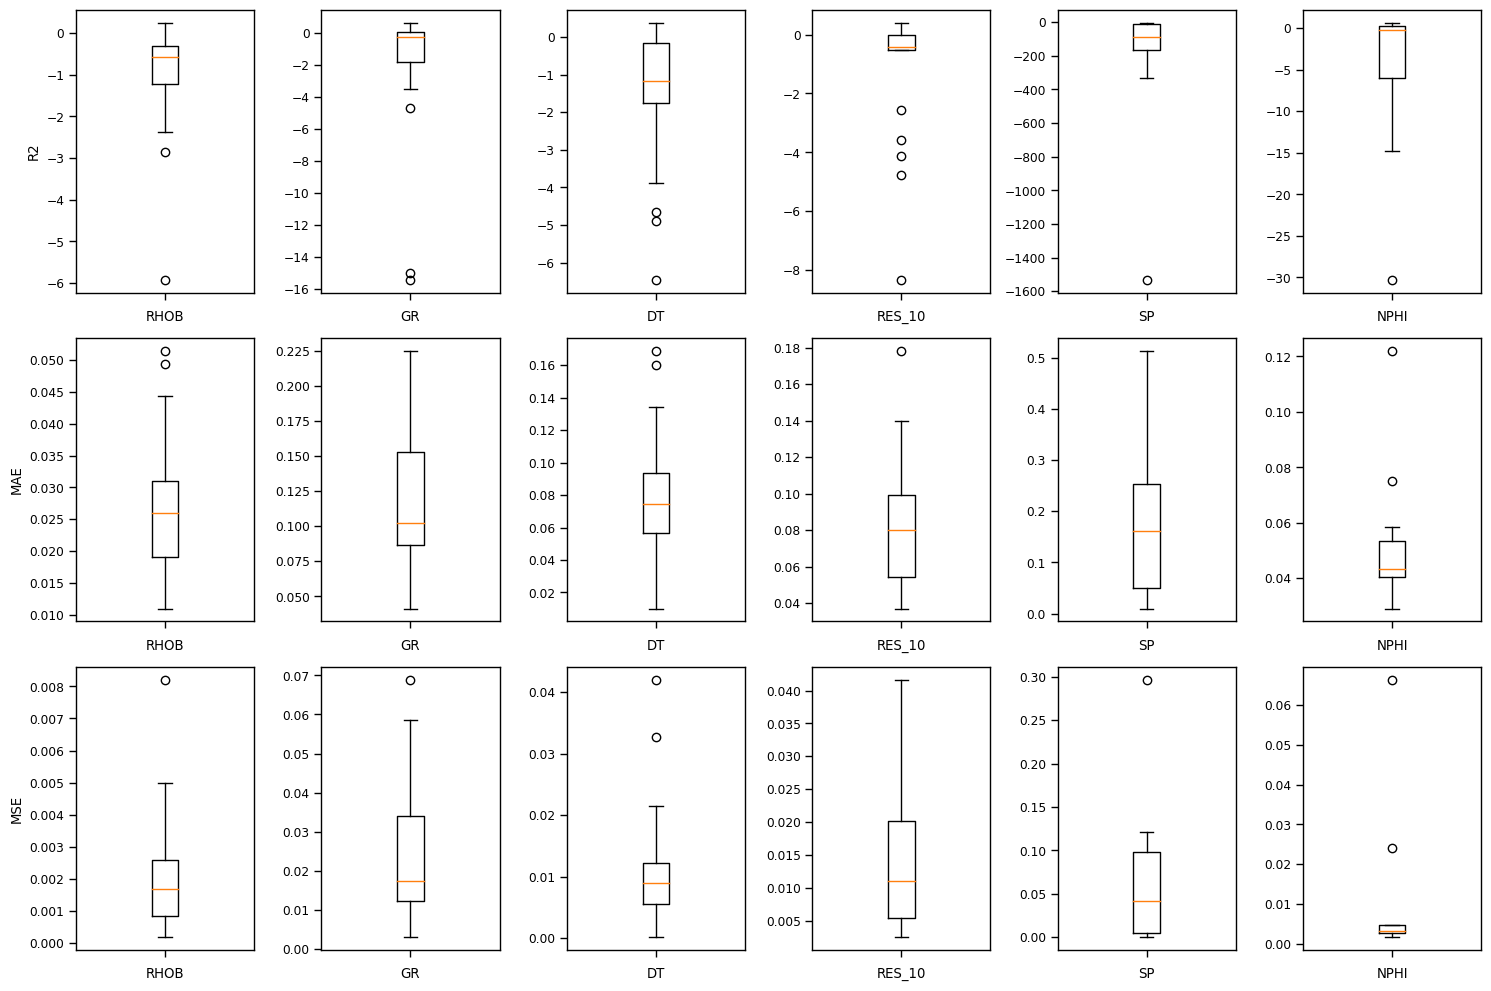

In [58]:
boxplot_results(results=train_results_knr, well_logs_plot=well_logs)

In [59]:
# save training results 
with open('train_results_knr.txt', 'w') as f:
    json.dump(train_results_knr, f)

In [60]:
scaler_knr, imp_model_knr = training_model(X_train=X_train, 
                                           model=KNeighborsRegressor, 
                                           param_grid=param_grid_knr,
                                           well_logs=imputed_cols,
                                           cols_imp=features_mice, 
                                           n_splits=5,
                                           n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### BayesianRidge

In [61]:
param_grid_br = {}

In [62]:
train_results_br, train_time_br = cv_training(X_train=X_train,
                                              model=BayesianRidge, 
                                              param_grid=param_grid_br,
                                              well_logs=imputed_cols,
                                              cols_imp=features_mice, 
                                              combinations=combinations, 
                                              n_splits=5,
                                              n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [63]:
print('Cross-Validation Time: {:.2f} seconds \n'.format(train_time_br))

Cross-Validation Time: 19.53 seconds 



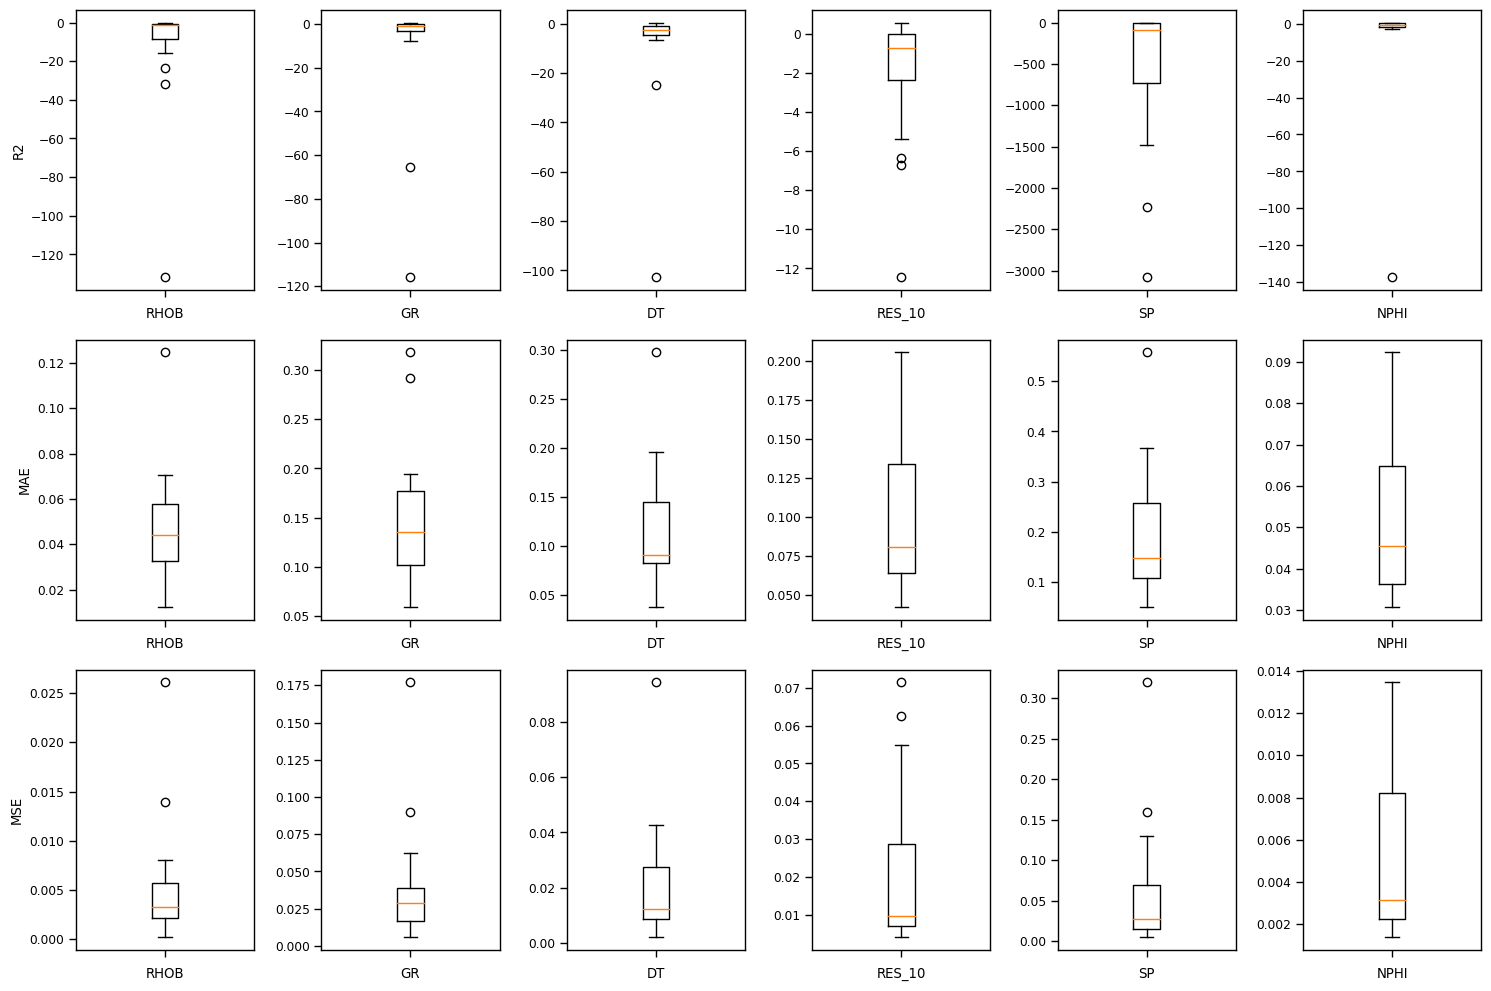

In [64]:
boxplot_results(results=train_results_br, well_logs_plot=well_logs)

In [65]:
# save training results 
with open('train_results_br.txt', 'w') as f:
    json.dump(train_results_br, f)

In [66]:
scaler_br, imp_model_br = training_model(X_train=X_train, 
                                         model=BayesianRidge, 
                                         param_grid=param_grid_br,
                                         well_logs=imputed_cols,
                                         cols_imp=features_mice, 
                                         n_splits=5,
                                         n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### RandomForestRegressor

In [67]:
param_grid_rf = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [68]:
train_results_rf, train_time_rf = cv_training(X_train=X_train,
                                              model=RandomForestRegressor, 
                                              param_grid=param_grid_rf,
                                              well_logs=imputed_cols,
                                              cols_imp=features_mice, 
                                              combinations=combinations,
                                              n_splits=5,
                                              n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [69]:
print('Cross-Validation Time: {:.2f} seconds \n'.format(train_time_rf))

Cross-Validation Time: 2215.75 seconds 



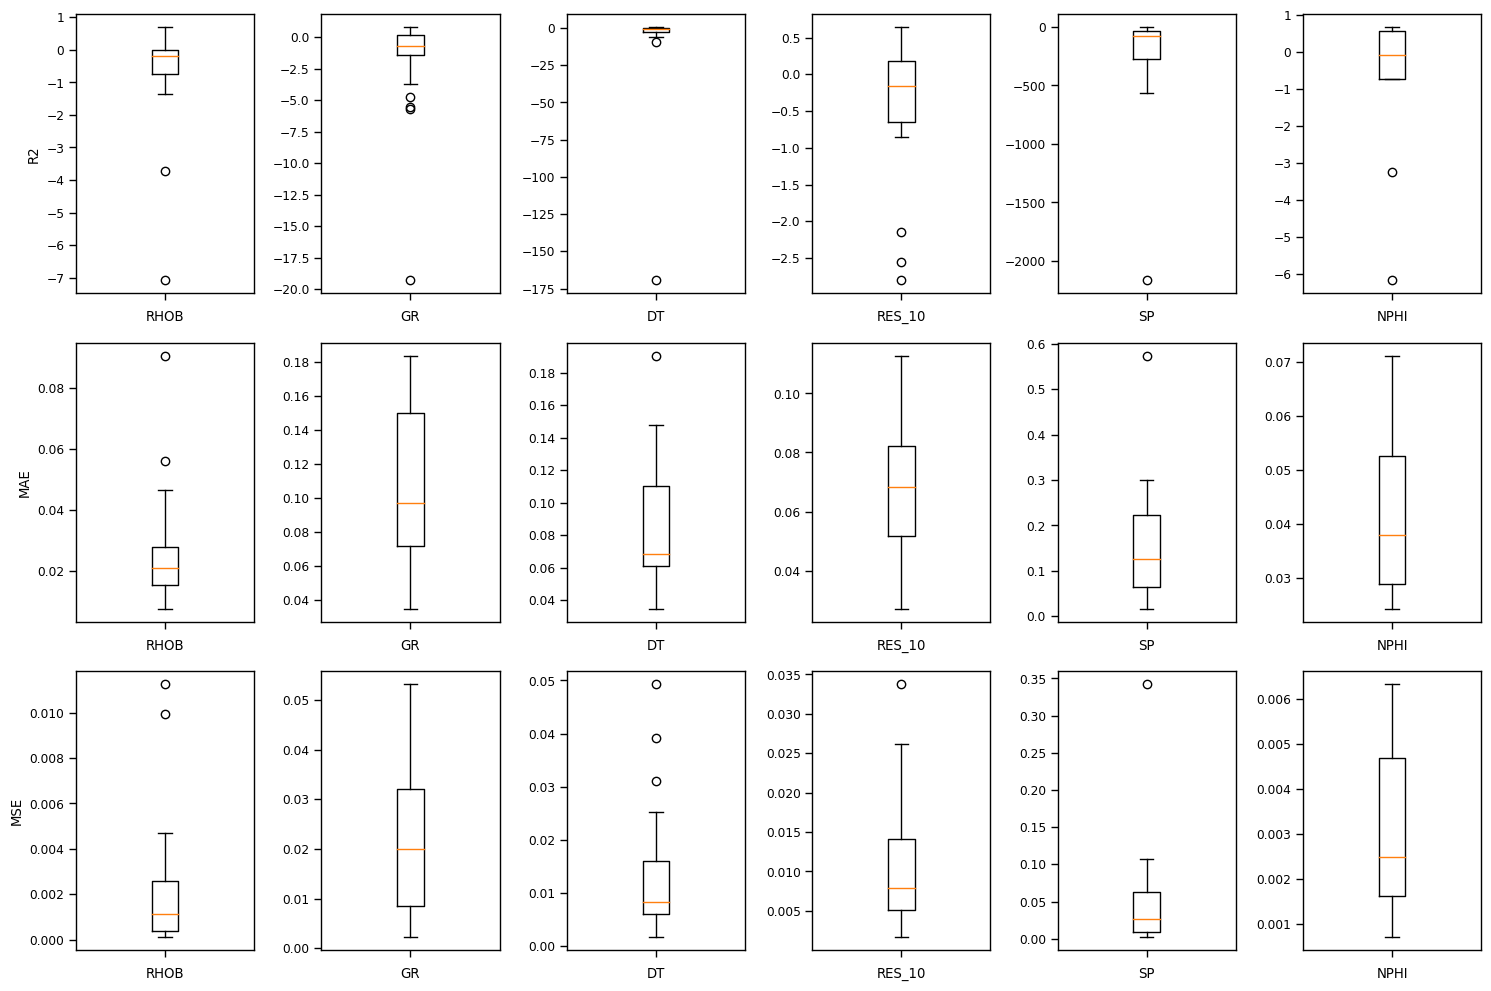

In [70]:
boxplot_results(results=train_results_rf, well_logs_plot=well_logs)

In [71]:
# save training results 
with open('train_results_rf.txt', 'w') as f:
    json.dump(train_results_rf, f)

In [72]:
scaler_rf, imp_model_rf = training_model(X_train=X_train, 
                                         model=RandomForestRegressor, 
                                         param_grid=param_grid_rf,
                                         well_logs=imputed_cols,
                                         cols_imp=features_mice, 
                                         n_splits=5,
                                         n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### XGBRegressor

In [73]:
param_grid_xgb = {'max_depth': 6, 'reg_lambda': 2}

In [74]:
train_results_xgb, train_time_xgb = cv_training(X_train=X_train,
                                                model=XGBRegressor, 
                                                param_grid=param_grid_xgb,
                                                well_logs=imputed_cols,
                                                cols_imp=features_mice, 
                                                combinations=combinations, 
                                                n_splits=5,
                                                n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [75]:
print('Cross-Validation Time: {:.2f} seconds \n'.format(train_time_xgb))

Cross-Validation Time: 1409.23 seconds 



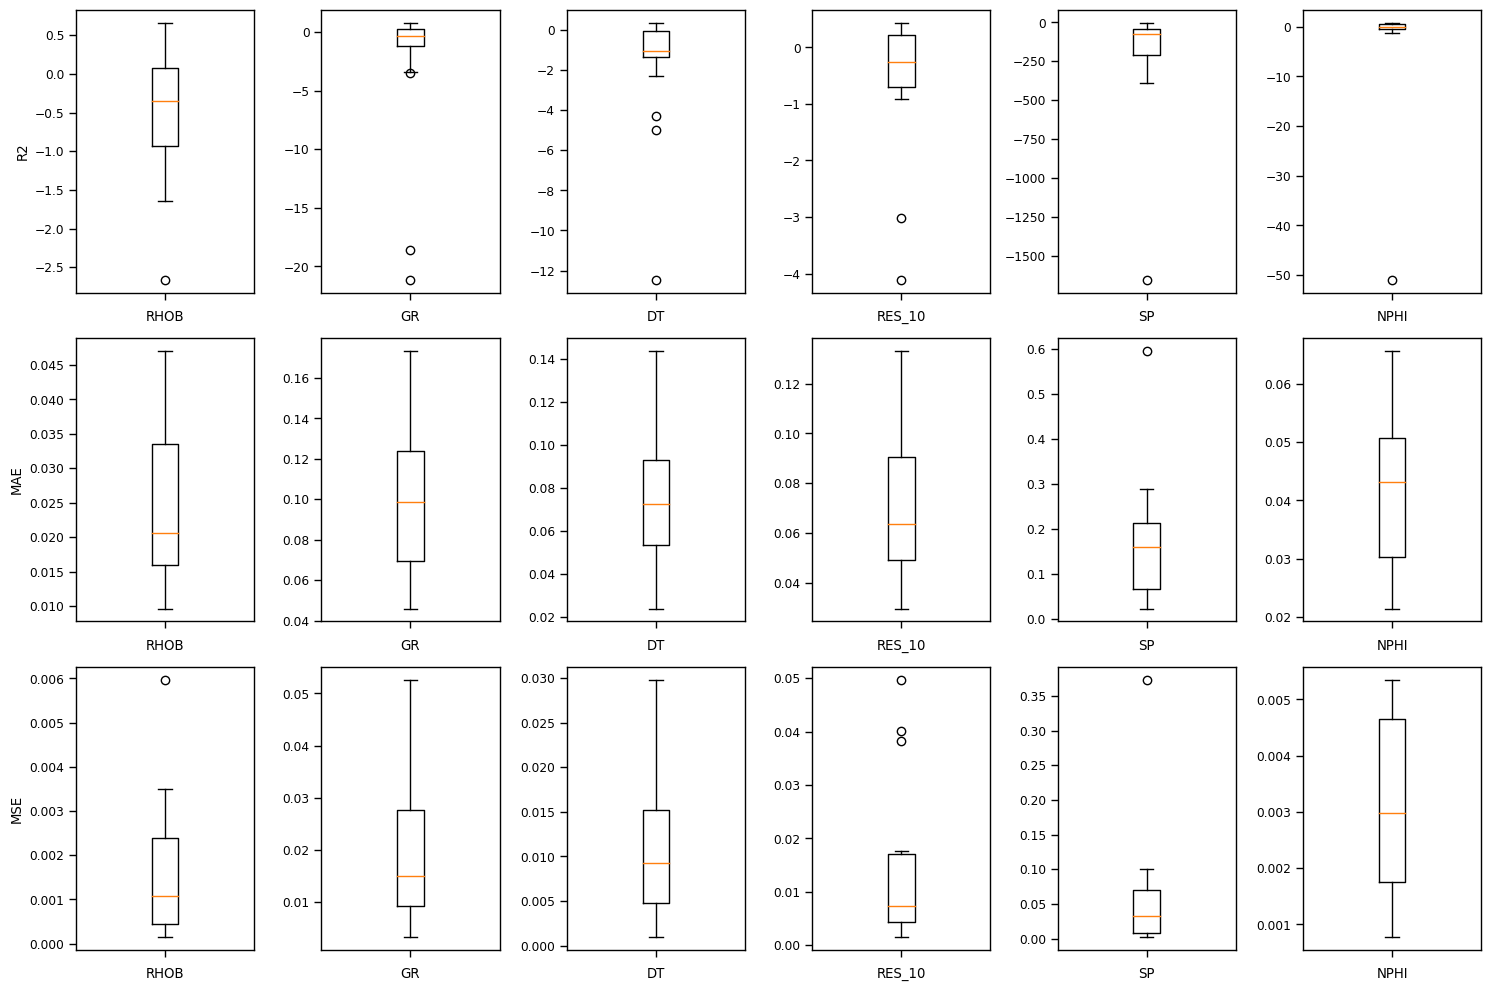

In [76]:
boxplot_results(results=train_results_xgb, well_logs_plot=well_logs)

In [77]:
# save training results 
with open('train_results_xgb.txt', 'w') as f:
    json.dump(train_results_xgb, f)

In [78]:
scaler_xgb, imp_model_xgb = training_model(X_train=X_train, 
                                           model=XGBRegressor, 
                                           param_grid=param_grid_xgb,
                                           well_logs=imputed_cols,
                                           cols_imp=features_mice, 
                                           n_splits=5,
                                           n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# 4. Testing Imputation

In [79]:
def testing_model(X_test, scaler, imp_model, well_logs, cols_imp, n_splits):
    """
    Impute Test Data using Train Model
    
    Parameters
    ------------------------------------------------------------------------
        X_test: (pd.DataFrame) 
            Test data
        
        scaler: (scaler object)
            Scaler object fitted on the training data
            
        imp_model: (imputation model object)
            Imputation model trained on the training data
            
        well_logs: (list)
            List of well logs to evaluate
            
        cols_imp: (list)
            List of columns to impute
            
        n_splits: (int)
            Number of cross-validation splits
    
    Returns
    ------------------------------------------------------------------------
        combined_df: (pd.DataFrame)
            Combined results dataframe containing original scaled values, 
            scaled imputed values, and imputed values for each well log
    """
    # scale the original test data
    X_test_original_scale = scaler.transform(X_test[cols_imp])        
    X_test_original_scale_df = pd.DataFrame(X_test_original_scale,
                                      columns=cols_imp,
                                      index=X_test.index)
    X_test_original_scale_df['WELL'] = X_test['WELL']
    
    unique_wells = X_test['WELL'].unique()
    combinations = []
    for well in unique_wells:
        for feature in imputed_cols:
            # only for well-logs that are not completely NaN
            if not X_test.loc[X_test['WELL'] == well, feature].isna().all():
                combinations.append((well, feature))
    
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    
    X_test_sc_imp_result = X_test.copy()
    X_test_imp_result = X_test.copy()
     
    for i, (test_index, val_index) in enumerate(kf.split(combinations)):

        # test and validations sets
        test_combinations = [combinations[i] for i in test_index]
        validation_combinations = [combinations[i] for i in val_index]

        # copy of the data to work with
        data_test = X_test.copy()
        
        # set values to NaN in the data to impute using the validation combinations
        for well_id, feature_name in validation_combinations:
            data_test.loc[data_test['WELL']==well_id, feature_name] = np.nan


        # scale the test with NaN using the scaler object fitted on the training data
        X_test_scaled = scaler.transform(data_test[cols_imp])
        X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                                        columns=cols_imp,
                                        index=X_test.index)

        # impute NaN values in the test data using the imp_model trained on the training data
        X_test_imp = imp_model.transform(X_test_scaled_df[cols_imp])
        X_test_imp_scaled = pd.DataFrame(X_test_imp, columns=cols_imp, index=X_test.index)

        
        # inverse transform the imputed values
        X_test_imp_unscaled = scaler.inverse_transform(X_test_imp_scaled)
        X_test_imp_df = pd.DataFrame(X_test_imp_unscaled, 
                                     columns=cols_imp, 
                                     index=X_test.index)
        
        
        # store results of the scaled imputation using validation combinations
        for well_id, feature_name in validation_combinations:
            scaled_imputed_result = X_test_imp_scaled.loc[X_test['WELL']==well_id, feature_name]
            X_test_sc_imp_result.loc[X_test['WELL']==well_id, feature_name] = scaled_imputed_result
        
        # store results of the imputation using validation combinations
        for well_id, feature_name in validation_combinations:
            imputed_result = X_test_imp_df.loc[X_test['WELL']==well_id, feature_name]
            X_test_imp_result.loc[X_test['WELL']==well_id, feature_name] = imputed_result
                
    # rename columns
    X_test_original_scale_df.rename(columns=lambda x: x + '_SCALED', inplace=True)
    X_test_sc_imp_result.rename(columns=lambda x: x + '_IMP_SCALED', inplace=True)
    X_test_imp_result.rename(columns=lambda x: x + '_IMP', inplace=True)
    
    # combine dataframes
    combined_df = pd.concat([X_test_original_scale_df[[column + '_SCALED' for column in well_logs]],
                             X_test_sc_imp_result[[column + '_IMP_SCALED' for column in well_logs]],
                             X_test_imp_result[[column + '_IMP' for column in well_logs]]
                            ], axis=1)

    return  combined_df

### KNeighborsRegressor

In [80]:
test_result_knr = testing_model(X_test=X_test, 
                                scaler=scaler_knr, 
                                imp_model=imp_model_knr,
                                well_logs=imputed_cols,
                                cols_imp=features_mice,
                                n_splits=5
                               )

In [81]:
# save results to csv file
test_result_knr.to_csv('test_result_knr.csv', index=False)

### BayesianRidge

In [82]:
test_result_br = testing_model(X_test=X_test, 
                               scaler=scaler_br, 
                               imp_model=imp_model_br,
                               well_logs=imputed_cols,
                               cols_imp=features_mice,
                               n_splits=5
                              )

In [83]:
# save results to csv file
test_result_br.to_csv('test_result_br.csv', index=False)

### RandomForestRegressor

In [84]:
test_result_rf = testing_model(X_test=X_test, 
                               scaler=scaler_rf, 
                               imp_model=imp_model_rf,
                               well_logs=imputed_cols,
                               cols_imp=features_mice,
                               n_splits=5
                              )

In [85]:
# save results to csv file
test_result_rf.to_csv('test_result_rf.csv', index=False)

### XGBRegressor

In [86]:
test_result_xgb = testing_model(X_test=X_test, 
                                scaler=scaler_xgb, 
                                imp_model=imp_model_xgb,
                                well_logs=imputed_cols,
                                cols_imp=features_mice,
                                n_splits=5
                               )

In [87]:
# save results to csv file
test_result_xgb.to_csv('test_result_xgb.csv', index=False)